In [1]:
# Standard library imports
from pathlib import Path
from typing import Optional
from datetime import datetime, timedelta, date

# Third party imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Local imports
from clean_data import clean_data

# Connect to a local SQLite database
%load_ext sql
%sql sqlite://

%matplotlib inline

In [2]:
# Check if a directory containing the cleaned data exists,
# and create a new one if it does not exist
data_path = Path('../data')
clean_data_path = data_path / 'clean_f1db'

if not clean_data_path.is_dir():
    raw_data_path = data_path / 'f1db_csv'
    clean_data(raw_data_path, clean_data_path)

In [3]:
# Define a function to read the given CSV file with Pandas, 
# and then return the DataFrame
def load_file(file_name: str, parse_dates: Optional[bool] = False):
    file_path = clean_data_path / (file_name + '.csv')
    return pd.read_csv(file_path, parse_dates=parse_dates)

In [4]:
# Load the CSV files and create SQL tables
drivers = load_file('drivers')
%sql --persist drivers

constr = load_file('constructors')
%sql --persist constr

results = load_file('results')
%sql --persist results

races = load_file('races')
%sql --persist races

circuits = load_file('circuits')
%sql --persist circuits

 * sqlite://
 * sqlite://
 * sqlite://
 * sqlite://
 * sqlite://


'Persisted circuits'

## SQL Table vs Pandas DataFrame
Notice the similarities between the two.

In [5]:
%sql SELECT * FROM drivers LIMIT 5;

 * sqlite://
Done.


index,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44.0,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,None,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6.0,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14.0,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,None,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [6]:
drivers.head()

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44.0,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,NaN,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6.0,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14.0,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,NaN,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


## Problem 1
Find the most successful constructors in F1 by race wins and plot the results.

In [7]:
%%sql
-- Find the total number of race wins for each constructor.
-- Only keep the top 10, this makes it easier to view the pie chart.
-- A win here means position = 1.

SELECT name, COUNT(*) AS count
  FROM results AS r
  JOIN constr AS c
    ON r.constructorId = c.constructorId
 WHERE position = 1
 GROUP BY r.constructorId
 ORDER BY count DESC
 LIMIT 10;

 * sqlite://
Done.


name,count
Ferrari,239
McLaren,178
Mercedes,115
Williams,114
Red Bull,64
Team Lotus,45
Renault,35
Benetton,27
Brabham,23
Tyrrell,23


In [8]:
# We can do the same with Pandas to verify the results
df = results[results['position'].astype('float') == 1]
df = df.groupby('constructorId').agg('count')
df = df.join(constr.set_index('constructorId'))

In [9]:
# Both methods produced the same result, but which one is easier to read?
df = df[['name', 'raceId']].sort_values('raceId', ascending=False)
df = df.head(10)
df

,name,raceId
constructorId,,
6,Ferrari,239
1,McLaren,178
131,Mercedes,115
3,Williams,114
9,Red Bull,64
32,Team Lotus,45
4,Renault,35
22,Benetton,27
25,Tyrrell,23


Text(0.5, 1.0, 'Number of Race Wins in Formula 1')

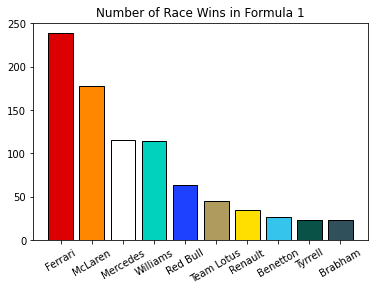

In [10]:
'''
Now we can produce a bar chart using the DataFrame. Since Matplotlib allows 
us to specify colors in the pie chart, we can use the colors that represent 
these teams.

Credits to www.f1colours.com, html-color-codes.info/colors-from-image/, and
www.reddit.com/r/formula1/comments/arxt0r/f1_2019_team_colors_hex_codes/
for the team colors.
'''

colors = ['#DC0000', '#FF8700', '#FFFFFF', '#00D2BE', '#1E41FF', 
          '#AF9B5E', '#FFDF00', '#35C4EC', '#095248', '#30505C']

plt.xticks(rotation=30)
plt.bar(df['name'], df['raceId'], color=colors, edgecolor='#000000');
plt.title('Number of Race Wins in Formula 1')

## Problem 2
Find the most successful constructors in F1 by win rate and plot the results.

Win rate is defined by number of race wins divided by number of race entries.

In [11]:
%%sql 
-- Similar to the previous query, first find the number of race wins
-- Then compute the number of race entries and divide

WITH race_wins(consId, wins) AS 
     (SELECT constructorId, COUNT(*)
        FROM results
       WHERE position = 1
       GROUP BY constructorId)


SELECT name, 
       ROUND(1.0 * W.wins / COUNT(*), 3) AS win_rate
  FROM constr AS c
       JOIN results AS r
       ON c.constructorId = r.constructorId
        
       JOIN race_wins AS w
       ON r.constructorId = w.consId
 GROUP BY r.constructorId
 ORDER BY win_rate DESC
 LIMIT 10;

 * sqlite://
Done.


name,win_rate
Mercedes,0.244
Brawn,0.235
Matra-Ford,0.225
Vanwall,0.141
Watson,0.136
Epperly,0.118
Ferrari,0.106
Red Bull,0.105
Brabham-Repco,0.104
McLaren,0.102


<BarContainer object of 10 artists>

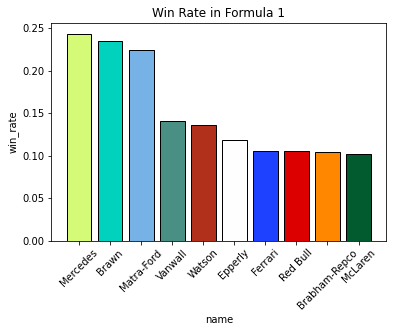

In [12]:
colors = ['#D5FA78', '#00D2BE', '#76B2E6', '#498F84', '#B0301C', 
          '#FFFEFF', '#1E41FF', '#DC0000', '#FF8700', '#025A2F']

plt.title('Win Rate in Formula 1')
_.bar(color=colors, edgecolor='#000000')

## Problem 3
Is the number of races each season increasing?

In [13]:
# Group by 'year' and aggregate by count
df = races.groupby('year').aggregate('count').reset_index()

In [14]:
# Find a best fit line
fit = stats.linregress(df['year'], df['raceId'])
df['fit'] = fit.slope * df['year'] + fit.intercept

Text(0, 0.5, 'Number of Races')

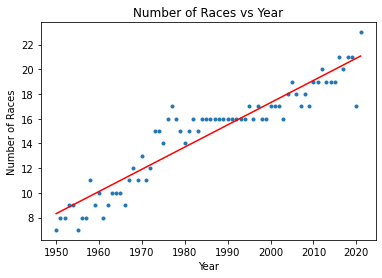

In [15]:
# Take a look at the results, is the slope increasing?
plt.plot(df['year'], df['raceId'], '.')
plt.plot(df['year'], df['fit'], 'r-')
plt.title('Number of Races vs Year')
plt.xlabel('Year')
plt.ylabel('Number of Races')

## Problem 4
Find all drivers that have won a drivers' championship title with Ferrari. 

In [16]:
%%sql
-- For every season, find each driver's total points.
-- Store the results of this query so we can use it again later.

CREATE TEMP TABLE standings(consId INT, drivId INT, year INT, points INT);

INSERT INTO Standings
SELECT constructorId, driverId, 
       year, SUM(points)
  FROM results AS re
  JOIN races AS ra
    ON re.raceId = ra.raceId
 GROUP BY driverId, year;

 * sqlite://
Done.
3122 rows affected.


[]

In [17]:
%%sql
-- The drivers that have scored the most points in a season are the
-- driver's champion. Keep entries where constructor name is Ferrari.

-- The sorting order of year is quite intersting.

WITH champions(consId, drivId, year) AS 
     (SELECT consId, drivId, 
             s.year
        FROM standings AS s
        JOIN (SELECT year, 
                     MAX(points) AS points
                FROM standings 
               GROUP BY year) AS ms
          ON s.year = ms.year
             AND s.points = ms.points)

    
SELECT forename, 
       surname,
       d.nationality, 
       ch.year
  FROM champions AS ch
  JOIN constr AS co
    ON ch.consId = co.constructorId
    
  JOIN drivers AS d
    ON ch.drivId = d.driverId
 WHERE co.name = 'Ferrari';

 * sqlite://
Done.


forename,surname,nationality,year
Kimi,Räikkönen,Finnish,2007
Michael,Schumacher,German,2000
Michael,Schumacher,German,2001
Michael,Schumacher,German,2002
Michael,Schumacher,German,2003
Michael,Schumacher,German,2004
Niki,Lauda,Austrian,1975
Niki,Lauda,Austrian,1977
Jody,Scheckter,South African,1979
Phil,Hill,American,1961


## Problem 5
Some drivers were very close to winning a title with Ferrari.

Find the ones that lost by no more than five points.

In [18]:
%%sql
-- Similar to the previous query, but instead of finding standings where
-- points = MAX(points), find ones where 0 < (points - MAX(points)) <= 5.

WITH close_champions(consId, drivId, year, points) AS 
     (SELECT consId, drivId, 
             s.year,
             ms.points - s.points
        FROM standings AS s
        JOIN (SELECT year, 
                     MAX(points) AS points
                FROM standings 
               GROUP BY year) AS ms
          ON s.year = ms.year
       WHERE s.points <> ms.points
         AND ms.points - s.points <= 5)

SELECT forename, surname,
       d.nationality, 
       ch.year, points
  FROM close_champions AS ch
  JOIN constr AS co
    ON ch.consId = co.constructorId
    
  JOIN drivers AS d
    ON ch.drivId = d.driverId
 WHERE co.name = 'Ferrari';

 * sqlite://
Done.


forename,surname,nationality,year,points
Fernando,Alonso,Spanish,2010,4
Fernando,Alonso,Spanish,2012,3
Felipe,Massa,Brazilian,2008,1
Michael,Schumacher,German,1997,3
Eddie,Irvine,British,1999,2
Alain,Prost,French,1990,5
Niki,Lauda,Austrian,1976,1
Didier,Pironi,French,1982,5
Clay,Regazzoni,Swiss,1974,3
Jacky,Ickx,Belgian,1970,5


In [19]:
%%sql
-- Now remove the temporary table that was created earlier.

DROP TABLE Standings;

 * sqlite://
Done.


[]

## Problem 6
Find all drivers to win a race before the age of 24.

In [20]:
'''
Issue: driver's date of birth has a different format than race dates.
We must convert them to the same format. We can do this by reading 
the csv files again with the parse_dates argument.
'''

ddrivers = load_file('drivers', parse_dates=['dob'])

%sql --persist ddrivers

draces = load_file('races', parse_dates=['date'])

%sql --persist draces

ddrivers['dob'].head(), draces['date'].head()

 * sqlite://
 * sqlite://


(0   1985-01-07
 1   1977-05-10
 2   1985-06-27
 3   1981-07-29
 4   1981-10-19
 Name: dob, dtype: datetime64[ns],
 0   2009-03-29
 1   2009-04-05
 2   2009-04-19
 3   2009-04-26
 4   2009-05-10
 Name: date, dtype: datetime64[ns])

In [21]:
%%sql 
-- Not quite right, we are missing Raikkonen, Kubica, and Fittipaldi
-- This could be a rounding error, as these drivers are included in
-- the results when date - dob < 25.

SELECT DISTINCT forename, surname
  FROM results re
  JOIN ddrivers d
    ON re.driverId = d.driverId
    
  JOIN draces r
    ON re.raceId = r.raceId
 WHERE position = 1
   AND date - dob < 24;

 * sqlite://
Done.


forename,surname
Lewis,Hamilton
Sebastian,Vettel
Fernando,Alonso
Michael,Schumacher
Jacky,Ickx
Bruce,McLaren
Troy,Ruttman
Max,Verstappen
Charles,Leclerc


In [22]:
%%sql
-- Joining the tables in Python then calculating the time delta
-- doesn't return the correct results either.

-- Idea: Join tables in SQL and compute the time delta in Python.

SELECT DISTINCT forename, surname,
       MIN(date) AS date, dob
  FROM results re
  JOIN ddrivers d
    ON re.driverId = d.driverId
    
  JOIN draces r
    ON re.raceId = r.raceId
 WHERE position = 1
   AND date - dob < 25
 GROUP BY forename, surname;

 * sqlite://
Done.


forename,surname,date,dob
Bruce,McLaren,1959-12-12 00:00:00.000000,1937-08-30 00:00:00.000000
Charles,Leclerc,2019-09-01 00:00:00.000000,1997-10-16 00:00:00.000000
David,Coulthard,1995-09-24 00:00:00.000000,1971-03-27 00:00:00.000000
Elio,de Angelis,1982-08-15 00:00:00.000000,1958-03-26 00:00:00.000000
Emerson,Fittipaldi,1970-10-04 00:00:00.000000,1946-12-12 00:00:00.000000
Fernando,Alonso,2003-08-24 00:00:00.000000,1981-07-29 00:00:00.000000
Jacky,Ickx,1968-07-07 00:00:00.000000,1945-01-01 00:00:00.000000
Jody,Scheckter,1974-06-09 00:00:00.000000,1950-01-29 00:00:00.000000
Kimi,Räikkönen,2003-03-23 00:00:00.000000,1979-10-17 00:00:00.000000
Lewis,Hamilton,2007-06-10 00:00:00.000000,1985-01-07 00:00:00.000000


In [23]:
# Convert the query results to a DataFrame
df = _.DataFrame()

In [24]:
# After the convertion 'date' and 'dob' are stored as strings,
# so convert them back to datetime format.
def convert2time(str):
    return datetime.strptime(str[:10], '%Y-%m-%d')

df['date'] = df['date'].apply(convert2time)
df['dob'] = df['dob'].apply(convert2time)

In [25]:
# Finally, calculate the drivers' age when they won the race
# and keep all entries where age < 24. 
df['age'] = df['date'] - df['dob']
df = df[df['age'] < timedelta(days=365*24)]

df = df[['forename', 'surname']].drop_duplicates()

In [26]:
df

,forename,surname
0,Bruce,McLaren
1,Charles,Leclerc
4,Emerson,Fittipaldi
5,Fernando,Alonso
6,Jacky,Ickx
8,Kimi,Räikkönen
9,Lewis,Hamilton
10,Max,Verstappen
11,Michael,Schumacher
14,Robert,Kubica


## Problem 7
Create a plot of Lewis Hamilton vs Sebastian Vettel in 2017

In [27]:
%%sql
-- Find the number of points these drivers received for
-- each race in 2017.

SELECT d.surname, re.points, c.country
  FROM races ra
  JOIN results re
    ON ra.raceId = re.raceId

  JOIN drivers d
    ON re.driverId = d.driverId
    
  JOIN circuits c
    ON ra.circuitId = c.circuitId
 WHERE year = 2017
   AND (surname = 'Hamilton'
       OR surname = 'Vettel');

 * sqlite://
Done.


surname,points,country
Hamilton,18.0,Australia
Vettel,25.0,Australia
Hamilton,25.0,China
Vettel,18.0,China
Hamilton,18.0,Bahrain
Vettel,25.0,Bahrain
Hamilton,12.0,Russia
Vettel,18.0,Russia
Hamilton,25.0,Spain
Vettel,18.0,Spain


In [28]:
df = _.DataFrame()

ham = df[df['surname'] == 'Hamilton'].copy()
vet = df[df['surname'] == 'Vettel'].copy()

shift = ham.shape[0]

ham['points'] = ham['points'].rolling(shift, min_periods=1).sum()
vet['points'] = vet['points'].rolling(shift, min_periods=1).sum()

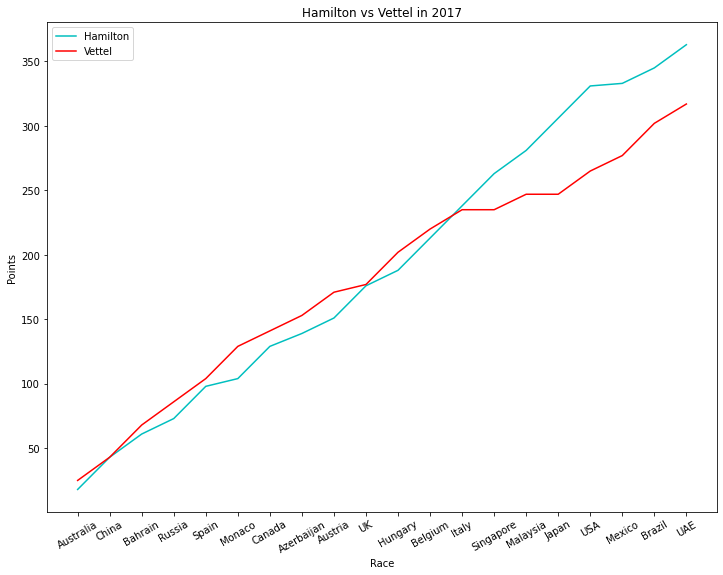

In [29]:
x = ham['country']

plt.figure(figsize=(12,9))
plt.plot(x, ham['points'], 'c-')
plt.plot(x, vet['points'], 'r-')

plt.xticks(rotation=30)
plt.xlabel('Race')
plt.ylabel('Points')
plt.title('Hamilton vs Vettel in 2017')
plt.legend(['Hamilton', 'Vettel'])

## Problem 8
Is the avearge duration of pit stops decreasing over time?

In [30]:
'''
Difficult problem to solve since some data cleaning is required.
First problem: raceId is between 841 and 1047, but the 1000th
race actually took place in 2019. Also, the duration of a pit
stop should be around 2 seconds rather than 20. So it would make
sense to divide the duration by 10.
Assume the given data is correct, this is how I would proceed.
'''

pit = load_file('pit_stops')
pit['duration'] = pit['milliseconds'] / 1000

pit.describe()

,raceId,driverId,stop,lap,duration,milliseconds
count,8030.000000,8030.000000,8030.000000,8030.000000,8030.000000,8.030000e+03
mean,932.706476,476.712827,1.767995,25.124159,52.729275,5.272927e+04
std,61.347956,395.415216,0.921017,14.353885,194.983076,1.949831e+05
min,841.000000,1.000000,1.000000,1.000000,12.897000,1.289700e+04
25%,879.000000,17.000000,1.000000,13.000000,21.903250,2.190325e+04
50%,930.000000,813.000000,2.000000,25.000000,23.459000,2.345900e+04
75%,982.000000,825.000000,2.000000,35.000000,25.813750,2.581375e+04
max,1047.000000,851.000000,6.000000,78.000000,2011.266000,2.011266e+06


Text(0, 0.5, 'Pit Stop Duration (seconds)')

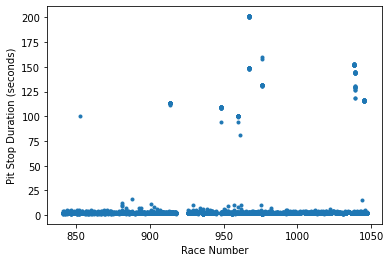

In [31]:
# Notice the outliers here, a normal pit stop should not take more 
# than a minute. So it makes sense to remove them for this question.
pit['duration'] /= 10

plt.plot(pit['raceId'], pit['duration'], '.')
plt.xlabel('Race Number')
plt.ylabel('Pit Stop Duration (seconds)')

In [32]:
# Now we can begin working on the data.
df = pit[pit['duration'] < 60].copy()
df = df.join(races, on='raceId', how='inner', rsuffix='races')
df = df.groupby('year').aggregate('mean').reset_index()

Text(0.5, 1.0, 'Average Pit Stop Duration over Time')

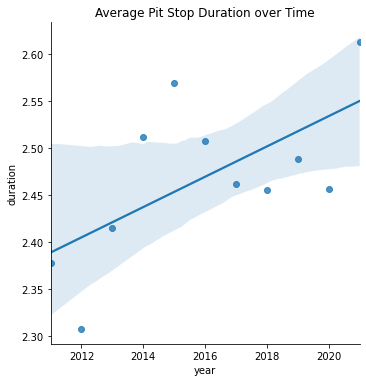

In [33]:
# Using seaborn, a higher-level plotting library. It seems
# like the average pit stop duration is actually increasing.
sns.lmplot(x='year', y='duration', data=df)
plt.title('Average Pit Stop Duration over Time')